In [53]:
## TO DO:
"""
1. Voltage or Heater?
2. Output gif
3. Histogram plots
4. vdrift/D
5. 
"""

'\n1. Voltage or Heater?\n2. Output gif\n3. Histogram plots\n4. V/D\n'

In [150]:
import numpy as np
voltages_temperatures = np.linspace(0.41, 0.51, 6, dtype=np.float32)
START = 776
SIZE = 15
sets = [range(START + SIZE * i, START + SIZE * (i + 1)) for i in range(len(voltages_temperatures))]
n_range = [i for i in sets]
n_range = [range(897,912), range(912,927) ,range(776, 791), range(791, 806), range(806, 821), range(821, 836)]
N = [len(i) for i in sets]
N= [len(i) for i in n_range]
m = MotionAnalyzer(n_range,voltages_temperatures,"electromigration_19")

In [154]:
m.analyze()

Frame 14: 24 trajectories present.
Before: 44
After: 30


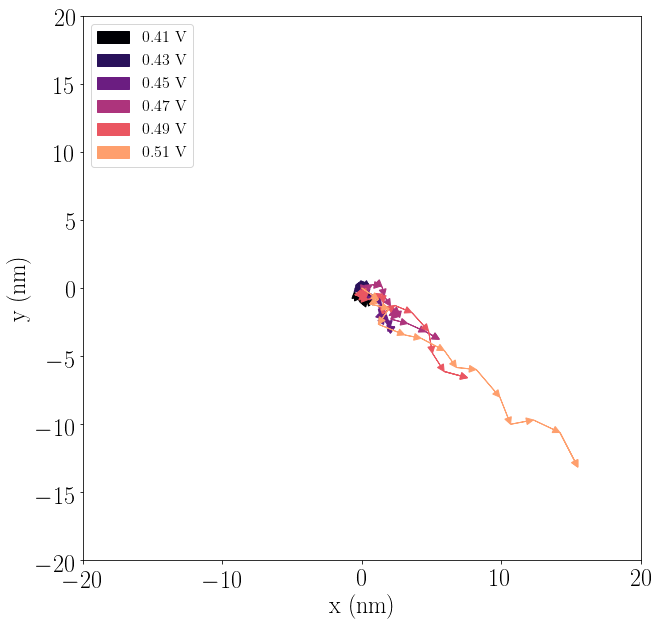

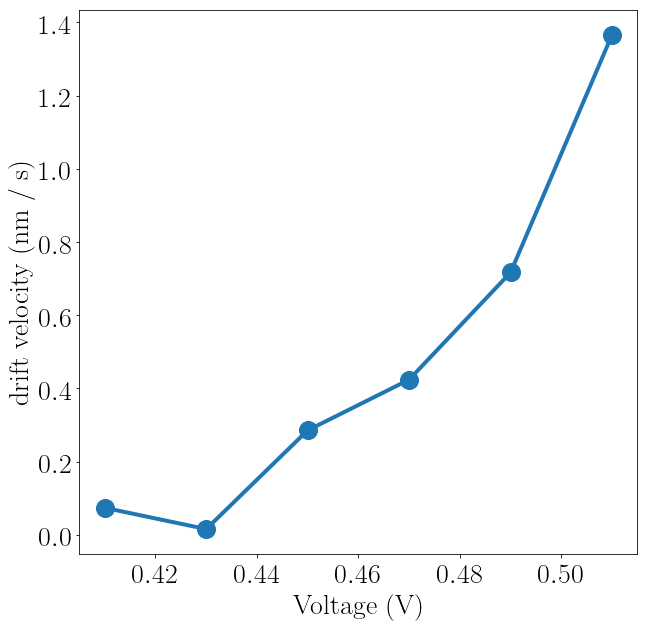

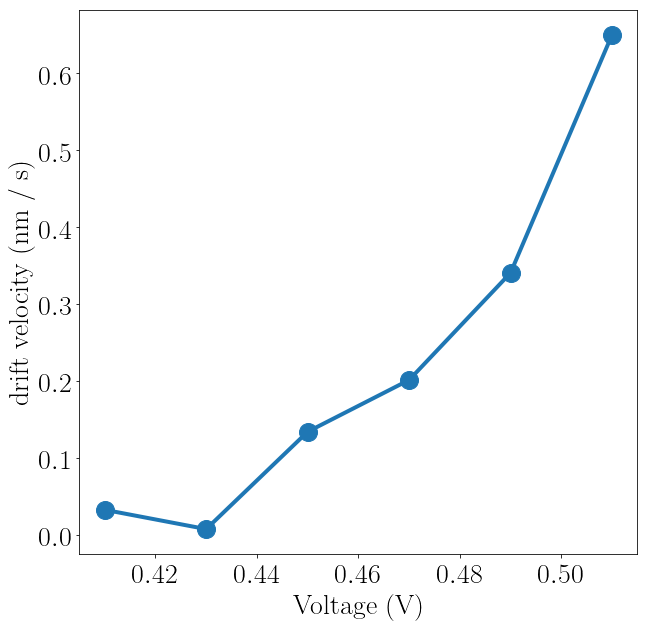

In [70]:
m.plot_drift_data()

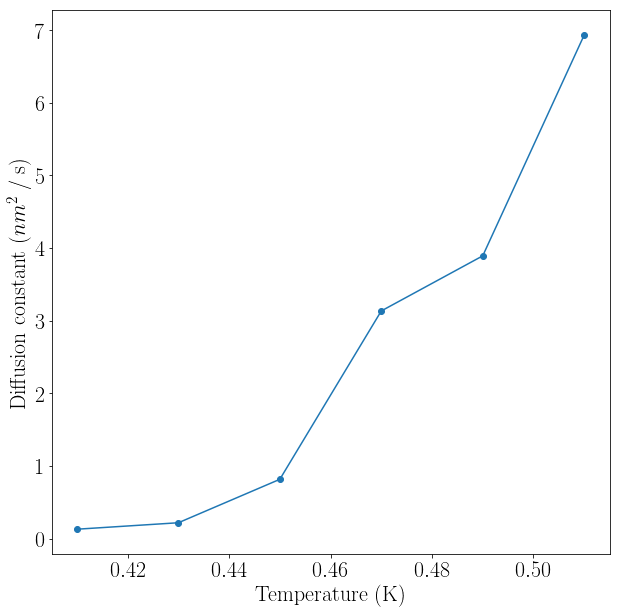

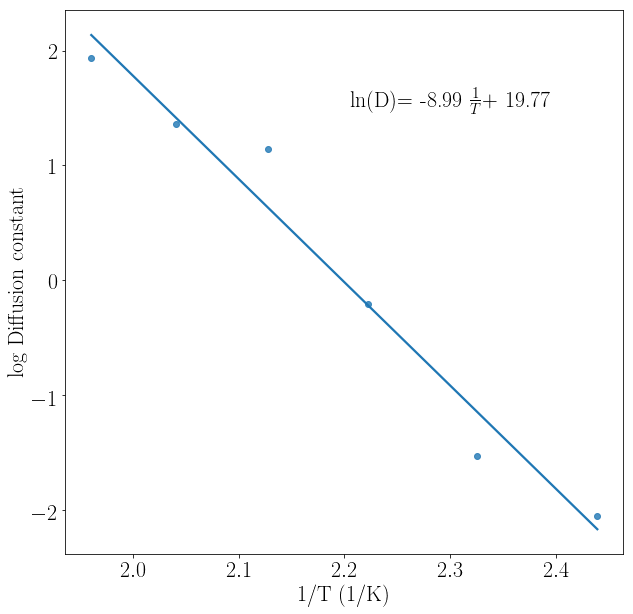

In [84]:
m.plot_diffusion()

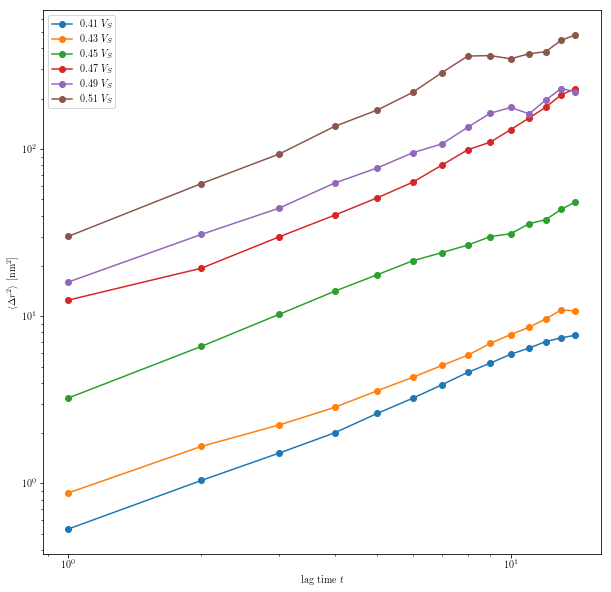

In [132]:
m.plot_msd()

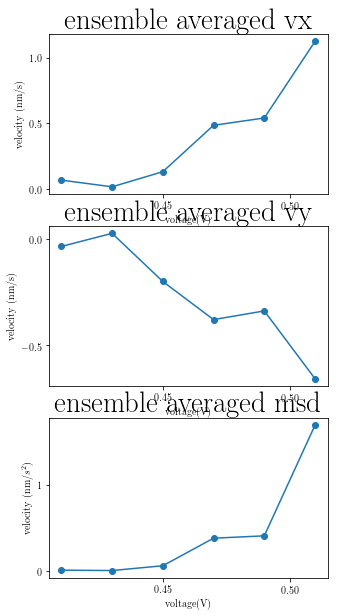

In [155]:
m.plot_ed()

In [156]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

from collections import namedtuple
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import linregress
import imageio
import seaborn as sns
import itertools

%matplotlib inline

import numpy as np
import pandas as pd
import trackpy as tp

from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename
from shutil import copyfile

import pims
import glob
from sxmreader import SXMReader
import yaml
    
class MotionAnalyzer:
    """
    A class used to analyze motion of particles on a series of images.

    Attributes
    ----------
    fileranges : range []
        a list of filenumber ranges corresponding to each set of images, e.g. [range(801,815), range(815,829)]  
    voltages_temperatures : np.float32 [] 
        a list of voltages or temperatures corresponding to each set of images
    D_constants:
    
    drifts:
    em: DataFrame []
    Ensemble averaged Mean Square Displacement (EMSD)
    ed: [<x>,<y>]
    Ensemble averaged Displacement
    SXM_PATH 
    : [str []]
        a list of list of paths corresponding to the filenames of each image
    ANALYSIS_FOLDER : str
        the folder where the analysis results will be saved.
    

    Methods
    -------
    analyze():
        Performs batch particle tracking and linking of tracks, calculates diffusion constants
        and drifts.
    plot_drift_vectors():
    
    """
        
    # Optionally, tweak styles.
    rc('animation', html='html5')
    mpl.rc('figure',  figsize=(5, 10))
    mpl.rc('image', cmap='gray')
    mpl.rc('image', origin='lower')

    
    def __init__(self, fileranges=None, voltages_temperatures=None, folder_name = None):
        
        if any((fileranges == None) or (voltages_temperatures == None)):
            print('no filerange or voltages/temperatures specified')
            return
        if len(n_range) != len(voltages_temperatures):
            print('number of sets and voltages/temperatures don\'t match')
        
        self.fileranges = fileranges
        self.voltages_temperatures = voltages_temperatures    
        self.SXM_PATH = [[folder_name + "/Image_{0:03}.sxm".format(i) for i in n_range[j]] for j in range(len(n_range))]
        self.SET_NAME = "{}-{}/".format(min([min(x) for x in n_range]), max([max(x) for x in n_range]))
        self.ANALYSIS_FOLDER = "./analysis/" + folder_name + "_" + self.SET_NAME
        self.PARAMS_FILENAME = "params.yaml"
        if not os.path.exists(self.ANALYSIS_FOLDER):
            os.makedirs(self.ANALYSIS_FOLDER)
        self.set_search_params()
        #self.analyze_drift()
        #self.plot_average_drift()
    
    def analyze(self):
        self.drifts = []
        self.D_constants = []
        self.mu_hats = []
        self.ed = []
        self.em = []
        for i, path in enumerate(self.SXM_PATH):
            frames = SXMReader(path)
            self.NM_PER_PIXEL = frames.meters_per_pixel * 1e9 
            molecule_size, min_mass, max_mass, separation, min_size, max_ecc, adaptive_stop, search_range, _ = self.PARAMS[i]
            f = tp.batch(frames, molecule_size, minmass=min_mass, separation=separation)
            t = tp.link(f, search_range=search_range, adaptive_stop=adaptive_stop)
            t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
                 (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
            t2 = tp.filter_stubs(t, 3)
            # Compare the number of particles in the unfiltered and filtered data.
            print('Before:', t['particle'].nunique())
            print('After:', t2['particle'].nunique())
            # Compute drifts
            d = tp.compute_drift(t2)
            d.loc[0] = [0, 0]
            t3 = t2.copy()
            # Storing drifts
            self.drifts.append(d)
            
            # Method 1 of calculating D: variance of all displacements of Delta_t=1
            displacements = self._calculate_displacements(t3)
            self.D_constants.append((displacements.dx.var() + displacements.dy.var()) / 4) # r^2 = x^2 + y^2 = 2Dt + 2Dt
            self.mu_hats.append(np.mean(displacements[['dx', 'dy']], axis=0))
            
            # Method 2 of calculating D: linear fit to MSD
            em = tp.emsd(t3, frames.meters_per_pixel*1e9, self.DIFFUSION_TIME, max_lagtime=len(frames) ,detail=True)
            self.em.append(em)
            self.ed.append([em['<x>'],em['<y>']])
            
    
    
    def plot_msd(self):
        fig, ax = plt.subplots(figsize=(10,10))
        for i in range(len(self.em)):
            ax.plot(self.em[i].index * self.DIFFUSION_TIME, self.em[i]['msd'], 'o-', label= "{:.2f} $V_S$".format(self.voltages_temperatures[i]))
            ax.legend()
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
            xlabel='lag time $t$')
        plt.savefig(self.ANALYSIS_FOLDER + "msd.png")
            
            
    def _calculate_displacements(self, t):
        displacements = pd.DataFrame()
        for j in range(t.frame.max() - 1):
                displacements = displacements.append(tp.relate_frames(t, j, j + 1) * self.NM_PER_PIXEL, ignore_index=True)
        return displacements

    
    def plot_drift_vectors(self):
        mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
        plt.figure(figsize=(10, 10))
        #colors = ['r', 'k', 'b', 'g', 'tab:orange', 'tab:purple', 'm']
        cmap = plt.cm.get_cmap("magma")
        colors = cmap(np.linspace(0,0.8,len(self.voltages_temperatures)))

        arrs = []
        j = 0
        for d in self.drifts:
            for i in range(1, len(d)):
                d0, d1 = d.loc[i - 1] * self.NM_PER_PIXEL, d.loc[i] * self.NM_PER_PIXEL
                plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
                shape='full', color=colors[j], length_includes_head=True, 
                zorder=0, head_length=0.5, head_width=0.5,linewidth=1)
            else:
                d0, d1 = d.loc[i - 1] * self.NM_PER_PIXEL, d.loc[i] * self.NM_PER_PIXEL
                arrs.append(plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
                shape='full', color=colors[j], length_includes_head=True, 
                zorder=0, head_length=0.5, head_width=0.5, label=str(voltages_temperatures[j])))
            j += 1
        new_labels, arrs = zip(*sorted(zip(voltages_temperatures, arrs)))
        new_labels=["{:.2f}".format(s) + ' V' for s in new_labels]
        plt.legend(arrs, new_labels, fontsize=16, loc='upper left')
        #plt.title("Ensemble Drift, " + SXM_PATH[0][0] + " to {}".format(SXM_PATH[-1][-1]))
        plt.xlabel("x (nm)",fontsize=24,fontweight='bold')
        plt.ylabel("y (nm)",fontsize=24,fontweight='bold')
        plt.xlim(-20, 20)
        plt.ylim(-20, 20)
        plt.savefig(self.ANALYSIS_FOLDER + "drift_vectors.png")
    
    def plot_drift_scalar(self,**kwargs):
        
        mag_displace = np.linalg.norm(self.mu_hats, 2, axis=1)
        new_labels, n_mag_displace, ord_D_constants = zip(*sorted(zip(self.voltages_temperatures, mag_displace, self.D_constants)))
        mpl.rcParams.update({'font.size' : 28, 'font.weight' : 'bold'})
        plt.figure(figsize=(10, 10))
        plt.plot(self.voltages_temperatures, mag_displace / self.DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
        # plt.plot(xx, yy / 1.5)
        plt.ylabel('drift velocity (nm / s)')
        plt.xlabel('Voltage (V)')
        plt.savefig(self.ANALYSIS_FOLDER + "drift_scalar.png")
        
        plt.figure(figsize=(10, 10))
        mean_mu_hat = self._calculate_mean_axis(self.mu_hats)
        proj_mag_displace = np.array(self._project_to_mean_axis(self.mu_hats,mean_mu_hat))
        plt.plot(self.voltages_temperatures,  proj_mag_displace / self.DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
        plt.ylabel('drift velocity (nm / s)')
        plt.xlabel('Voltage (V)')
        plt.savefig(self.ANALYSIS_FOLDER + "drift_scalar_projected.png")

    def plot_diffusion(self):
        font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

        mpl.rc('font', **font)
        mpl.rc('text',usetex =True)
        fig, ax = plt.subplots(figsize=(10,10))
        tmpv, _sorted_D_constants = (list(t) for t in zip(*sorted(zip(self.voltages_temperatures, self.D_constants))))
        ax.plot(np.array(tmpv), _sorted_D_constants,'o-')
        plt.xlabel('Temperature (K)')
        plt.ylabel('Diffusion constant ($nm^2$ / s)')
        plt.savefig(self.ANALYSIS_FOLDER + "D_constant_exp.png")

        fig, ax1 = plt.subplots(figsize=(10,10))
        sns.regplot(np.reciprocal(tmpv), np.log(_sorted_D_constants), 'o-', ci=None, ax=ax1)
        result = linregress(np.reciprocal(tmpv), np.log(_sorted_D_constants))
        plt.xlabel('1/T (1/K)')
        plt.ylabel('log Diffusion constant')
        ax1.annotate(r'ln(D)= {slope:.2f} $\frac{{1}}{{T}}$+ {intercept:.2f}'.format(slope=result.slope,intercept = result.intercept),xy=(350,500), xycoords='figure pixels')
        plt.savefig(self.ANALYSIS_FOLDER + "logD_constant_lin.png")
    
    def _calculate_mean_axis(self, mu_hats):
        return sum(mu_hats)/len(mu_hats)
    
    def _project_to_mean_axis(self, mu_hats, mean_mu_hat):
        return [np.dot(v,mean_mu_hat) for v in mu_hats]
    
    def plot_drift_data(self):
        self.plot_drift_vectors()
        self.plot_drift_scalar()
          
    def make_gif(self):
        pass
    
    def set_search_params(self):
        with open('params.yaml') as f:
            params = yaml.load(f, Loader=yaml.FullLoader)       
        Params = namedtuple(
                    'Params', 
                    ['molecule_size', 
                     'min_mass',
                     'max_mass',
                     'separation',
                     'min_size',
                     'max_ecc',
                     'adaptive_stop',
                     'search_range',
                     'diffusion_time'])
        self.DIFFUSION_TIME = params['diffusion_time']
        self.PARAMS = [Params(**params) for i in range(len(voltages_temperatures))]
        copyfile(self.PARAMS_FILENAME, self.ANALYSIS_FOLDER + self.PARAMS_FILENAME)
    
    def plot_ed(self):
        fig, axs = plt.subplots(3)
        t = [i for i in range(1,len(m.ed[0][0])+1)]
        vx = []
        vy = []
        for i, volt in enumerate(self.voltages_temperatures):
            slope, intercept, _, _, _ = linregress(t[:-5],self.ed[i][0][:-5])
            #print("vx={:.2f}nm/s".format(slope))
            vx.append(slope)
            slope, intercept, _, _, _ = linregress(t[:-5],self.ed[i][1][:-5])
            #print("vy={:.2f}nm/s".format(slope))
            vy.append(slope)
        mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})


        axs[0].plot(self.voltages_temperatures,vx,'o-')
        axs[0].set_title('ensemble averaged vx')
        axs[1].plot(self.voltages_temperatures,vy,'o-')
        axs[1].set_title('ensemble averaged vy')
        axs[2].plot(self.voltages_temperatures,np.array(vx)**2 + np.array(vy)**2,'o-')
        axs[2].set_title('ensemble averaged msd')

        for i in range(3):
            axs[i].set_xlabel('voltage(V)')
            axs[i].set_ylabel('velocity (nm/s)')
            if i == 2:
                axs[i].set_ylabel('velocity (nm/$s^2$)')
        plt.savefig(self.ANALYSIS_FOLDER + "ensemble averaged v.png")


In [1019]:
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

(-50, 50)

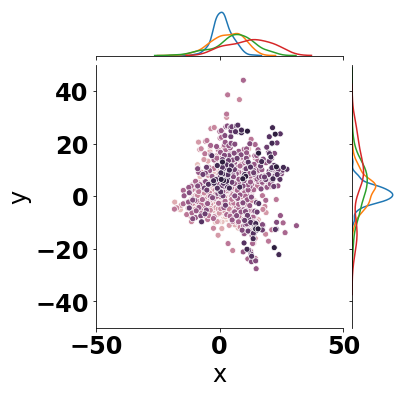

In [1020]:
scatter_df=pd.DataFrame(data=scatter_displacement, columns = ['x','y'])
scatter_df['interval'] = [i for i in range(0,len(frames))]
scatter_df = explode(scatter_df, lst_cols=list('xy'))
filtered_scatter_df = scatter_df[scatter_df['x'].map(type)!=str]
scatter_df = filtered_scatter_df
grid = sns.JointGrid(x='x', y='y', data=scatter_df)
g = grid.plot_joint(sns.scatterplot, hue='interval', data=scatter_df)
sns.kdeplot(scatter_df.loc[scatter_df['interval']== 1 , 'x'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==3, 'x'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==6, 'x'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==13, 'x'], ax=g.ax_marg_x, legend=False)

sns.kdeplot(scatter_df.loc[scatter_df['interval']==1, 'y'], ax=g.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==3, 'y'], ax=g.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==6, 'y'], ax=g.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==13, 'y'], ax=g.ax_marg_y, vertical=True, legend=False)

plt.legend().remove()
plt.xlim([-50,50])
plt.ylim([-50,50])

Text(0.5, 0, 'Voltage (V)')

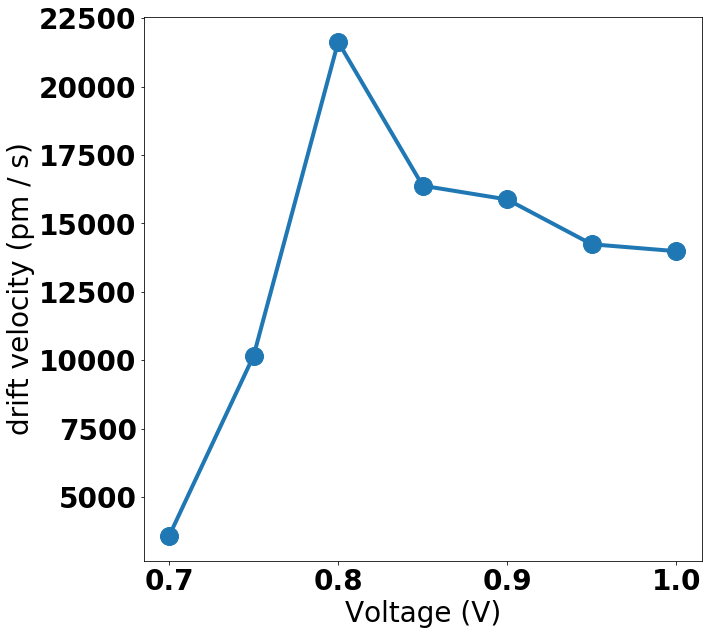

In [187]:
import scipy
DIFFUSION_TIME = 1 # in seconds
endpoints = np.array([d.iloc[-2] * NM_PER_PIXEL / DIFFUSION_TIME for d in drifts])
mag_displace = np.linalg.norm(endpoints, 2, axis=1)
new_labels, n_mag_displace, ord_D_constants = zip(*sorted(zip(voltage, mag_displace, D_constants)))
def exponential_func(x, a, b):
    return a*np.exp(-b*x)

# popt, pcov = scipy.optimize.curve_fit(exponential_func, new_labels, mag_displace)

# xx = np.linspace(0.9, 1.4, 100)
# yy = exponenial_func(xx, *popt)
import matplotlib
matplotlib.rcParams.update({'font.size' : 28, 'font.weight' : 'bold'})
plt.figure(figsize=(10, 10))
plt.plot(voltage, mag_displace * 1e3, '-o', markersize=18, linewidth=4)
# plt.plot(xx, yy / 1.5)
plt.ylabel('drift velocity (pm / s)')
plt.xlabel('Voltage (V)')

NameError: name 'exponential_func' is not defined

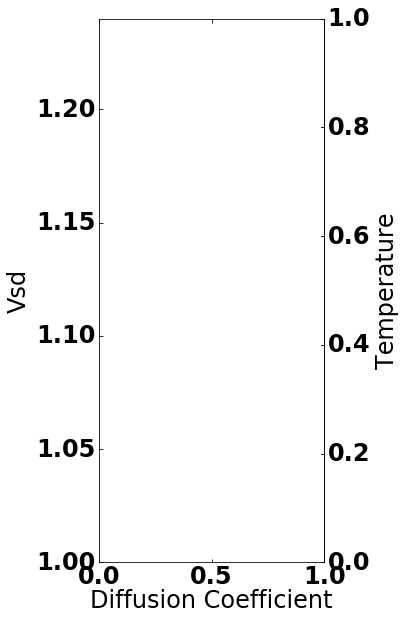

In [78]:
"""
Parasite axis demo

The following code is an example of a parasite axis. It aims to show a user how
to plot multiple different values onto one single plot. Notice how in this
example, par1 and par2 are both calling twinx meaning both are tied directly to
the x-axis. From there, each of those two axis can behave separately from the
each other, meaning they can take on separate values from themselves as well as
the x-axis.
"""
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 0
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par2.axis["right"].toggle(all=True)

host.set_xlabel("Diffusion Coefficient")
host.set_ylabel("Vsd")
host.set_ylim(1, 1.24)
par1.set_ylabel("Temperature")
par2.set_ylabel("Temperature")
Vsd = np.abs(np.array([-1.3, -1.225, -1.15, -1.075, -1.0]))

v_d = np.array([17.43212689649283,
         11.777233189697016,
         4.366861338228251,
         1.7498151858787845,
         0.6145379907911179])
popt, pcov = scipy.optimize.curve_fit(exponential_func, Vsd, v_d)

v_xx = np.linspace(1, 1.3, 100)
v_yy = exponential_func(v_xx, *popt)
p1, = host.plot(v_d, Vsd, 'bo', label="Vsd")
p1_fit, = host.plot(v_yy, v_xx, label="Vsd_fit")
temp = np.array([16.0, 17.0, 18.0, 19.0, 20.0])
temp_d = np.array([0.8248499990567321,
         1.1601072114062563,
         3.135702343676707,bb
         6.368734022432294,
         10.3054668679748])
popt, pcov = scipy.optimize.curve_fit(exponential_func, temp, temp_d)

t_xx = np.linspace(16, 20, 100)
t_yy = exponential_func(t_xx, *popt)
p2, = par2.plot(temp_d, temp, 'ro', label="Temperature")
p2_fit, = par2.plot(t_yy, t_xx, label="Temperature Fit")
par1.set_ylim(16, 20)
host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())

plt.draw()
plt.show()

In [ ]:
import scipy
def exponenial_func(x, a, b):
    return a * np.exp(-b / x )

plt.figure(figsize=(7,5))
popt, pcov = scipy.optimize.curve_fit(exponenial_func, tmpv[:], D_constants[:])

xx = np.linspace(voltage[0], voltage[-1], 100)
yy = exponenial_func(xx, *popt)
plt.plot(xx, yy)
plt.plot(tmpv, np.array(D_constants), 'o')
plt.xlabel('$V_{SD} (V)$')
plt.ylabel('$D (nm^2/s)$')

plt.figure(figsize=(7,5))
v_drift = np.array([0.0881857 , 0.01721636, 0.30606802, 0.41797495, 0.71354962,
       1.37261721])
popt1, pcov1 = scipy.optimize.curve_fit(exponenial_func, tmpv[:], v_drift[:])
                   
xx1 = np.linspace(voltage[0], voltage[-1], 100)
yy1 = exponenial_func(xx1, *popt1)
plt.plot(xx1, yy1)
plt.plot(tmpv, v_drift, 'o')
plt.xlabel('$V_{SD} (V)$')
plt.ylabel('$v_{drift} (nm/s)$')

plt.figure(figsize=(7,5))
xx2 = np.linspace(voltage[0], voltage[-1], 100)
yy2 = exponenial_func(xx2, *popt)/exponenial_func(xx2, *popt1)
plt.plot(xx2, yy2)
plt.plot(tmpv, D_constants/v_drift, 'o')
plt.xlabel('$V_{SD} (V)$')
plt.ylabel('$D / v_{drift}\ (nm)$')
